В нейронных сетях предпочтительно используется модель $y=f(u)$, где $u=\sum_{i=1}^n w_i x_i+w_0 x_0$ является детерминистическим искусственным нейроном., так же существует модель стохастического нейрона. 

$$
f(u)= \begin{cases}1 & \text {, с вероятностью } P(u) \\ 0 & \text {, с вероятностью } 1-P(u)\end{cases}
$$

Где распределение вероятности $P(u)$ обычно имеет вид сигмоида:

$$
\sigma(u)=\frac{A(T)}{1+\exp (-u / T)},
$$
Главный недостаток этого метода заключается в том, что в роли передаточной функции используется пороговая функция. Её производная равна 0, что не позволяет использовать стохастические нейроны в классическом варианте обучения с применением методов градиентного спуска и обратного распространения ошибки.

Авторы исследования предложили 2 подхода по оценке градиентов для стохастических нейронов:
1) простая "биологическая" модель нейрона с несмещенной и зашумленной оценкой градиента, которую можно применять для обучения с подкреплением;
2) прогнозирование с использованием смещения. (работает только с нелинейностями)


# 1 подход

Рассмотрим выход  $h_i$ стохастического нейрона, как применение детерменированной функции, которая зависит от входных данных $x_i$, внутренних параметров $\theta_i$, как веса и смещение, а так же вводится источник шума $z_i$ 
$$
h_i=f\left(x_i, z_i, \theta_i\right)
$$

Пример подобной функции
$$
h_i=\max \left(0, z_i+b_i+\sum_j W_{i j} x_{i j}\right)
$$

В данной интерпретации нейрона обучение ведется до тех пор, пока существуют ненулевые градиенты относительно $x_i$ и $\theta_i$ . Если накладывать дополнительное условие на бинарность выхода $h_i$, то окажется, что почти везде градиенты будут равны 0, поэтому дальнейшее обучение невозможно.

Авторы исследования определяют 2 состояния нейрона : активный и неактивный 



- Активный нейрон
$
f\left(x_i, 0, \theta_i\right)>0
$
Блок ненулевой и градиенты больше 0, но иногда отключается. В этом состоянии градиенты передаются для обучения, при этом возможен переход в неактивное состояние, если об этом сигнализирует основная часть модели.

- Неактивный нейрон
$
f\left(x_i, 0, \theta_i\right)=0
$
В подавляющем числе случае он равен 0, и занулены градиенты для дальнейшего обучения. Так же возможны ситуации, когда $z_i$ достаточно большое, чтобы перевести нейрон в активное состояние.

Таким образом при "биологической" модели нейрона у нас почти всегда есть ненулевые градиенты, которые позволят обучать всю сеть. С этим подходом связаны 2 основных недостатка: разная вероятность перехода состояний "активный" $\rightarrow$ "неактивный" и "неактивный" $\rightarrow$ "активный", а так же ситуация, когда часть нейронов будут неактивными и не будут использованы в дальнейшей работе модели.

# 2 подход

Рассмотрим случай с пороговым решением, но чтобы с некоторой вероятностью оно было дифферинцируемо. Вероятность является непрерывной функцией, так же предпологаем паралленость для разных батчей в процессе обучения через градиентный спуск. 

Рассмотрим пример, где $x_i$ влияет на функцию потерь L
$h_i=f\left(x_i, z_i, \theta_i\right)=\mathbf{1}_{z_i>\sigma\left(a_i\right)}$

$\sigma(x)$ - сигмоид,   $z_i $ ~ $U[0,1]$

И для случая детерминистического искусственного нейрона мы получаем  
$$
a_i=b_i+W_i \cdot x_i
$$

$b_i$ и $W_{i}$ являются $ \theta_{i} = (b_{i}, W_{i}) $ параметрами

# Теорема.

Пусть $h_i=f\left(x_i, z_i, \theta_i\right)=\mathbf{1}_{z_i>\sigma\left(a_i\right)}$ тогда  определим $\hat{g}_i=\left(h_i-\sigma\left(a_i\right)\right) $ как несмещенную оценку $$g_i=\frac{\partial E_{x_i, c_{-i}}\left[L \mid c_i\right]}{\partial a_i},$$ где матожидание шума $z_i$ и всех источников шума $с_{-i}$ не влияет на веса $a_i$, но влияет на функцию потерь L.

$
E_{v_z}[\cdot] \text { означает матожидание величины } v_z
$



<!-- Let $h_i$ be defined as in Eq. 2, then $\hat{g}_i=\left(h_i-\sigma\left(a_i\right)\right) L$ is an unbiased estimator of $g_i=\frac{\partial E_{x_i, c_{-i}}\left[L \mid c_i\right]}{\partial a_i}$ where the expectation is over $z_i$ and over all the noise sources $c_{-i}$, besides $z_i$, that do not influence $a_i$ but may influence $L$, i.e., conditioned on the set of noise sources $c_i$ that influence $a_{i-}$ -->


# Следствие.
При тех же условиях, что и в предыдущей теореме, а так же для любой(возможно неспецифичной) константы $\bar{L}_i$ вводится центральная оценка
$
\left(h_i-\sigma\left(a_i\right)\right)\left(L-\bar{L}_i\right),
$
несмещенная оценка $g_i=\frac{\partial E_{x_i, c_{-i}}\left[\left.L\right|_{\left.c_i\right]}\right.}{\partial a_i}$. Более того, среди всех возможных значений $\bar{L}_i$, минимальная дисперсия равна
$$
\bar{L}_i=\frac{E\left[\left(h_i-\sigma\left(a_i\right)\right)^2 L\right]}{E\left[\left(h_i-\sigma\left(a_i\right)\right)^2\right]},
$$
который является средневзвешенным значеием потерь L, веса которого специфичны для каждого экземпляра i.

 Таким образом исследователями предложено 2 способа по оценке градиентов стохастических нейронов для дальнейшего обучения модели

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt


# Условия задачи
$$
s^2 \sum_i^n\left(\frac{x_i}{s}-\operatorname{sign}\left(\frac{x_i}{s}\right)\right)^2 \rightarrow \min _s
$$


$$
f(x,s)  = s^2 \sum_i^n\left(\frac{x_i}{s}-\operatorname{sign}\left(\frac{x_i}{s}\right)\right)^2 = \sum_i^n\left(x_{i}-s * \operatorname{sign}\left(\frac{x_i}{s}\right)\right)^2  = \sum_i^n\left(x_{i}^2-2 x_{i} s * \operatorname{sign}\left(\frac{x_i}{s}\right) + (s * \operatorname{sign}\left(\frac{x_i}{s})\right)^2\right) = \sum_i^n\left(x_{i}-s * \operatorname{sign}\left(\frac{x_i}{s}\right)\right)^2  =$$

$$= \sum_i^n\left(x_{i}^2-2 x_{i} s * \operatorname{sign}\left(\frac{x_i}{s}\right) + s^2\right)
$$


В силу определения sign(х) и без рассмотрения точки s = 0
$$ (\operatorname{sign}\left(\frac{x_i}{s}\right)  )^2= 1$$ 


Пусть S>0, при S=0 у нас деление на 0 и функция не определена в этой точке.
Для получения точного аналитического решения ищем точку экстремума.
$$\frac{\partial f}{\partial s} = 0$$

$$\frac{\partial f}{\partial s} = \sum_i^n\left(-2 x_{i}  \operatorname{sign}\left({x_i}\right) + 2s\right) = \sum_i^n\left(-2|x_{i}| + 2s\right)$$

 $$\sum_i^n\left(-2|x_{i}| + 2s\right) = \sum_i^n\left(-2|x_{i}|\right) +2sn = 0$$

$$s = \frac{\sum_i^n\left(|x_{i}|\right)}{n} $$

Аналогично для случая S<0 получается.
$$s = -\frac{\sum_i^n\left(|x_{i}|\right)}{n} $$

In [2]:
mu, sigma, n, s = 0, 1, 100, 1 # параметры нормального распределения, количество сэмплированных точек и начальное приближение S, чтобы избежать деления на 0
sample = np.random.normal(mu, sigma, n)
s_min1 = np.sum(abs(sample))/n
s_min2 = -np.sum(abs(sample))/n

def f(x, s): # исходная функция
    return np.sum((x- s * np.sign(x/s))**2)

if f(sample,s_min1) == f(sample,s_min2):
    print('Минимальное значение функции: ' + str(f(sample,s_min1) ))
    print('Значения S, при котором достигается минимум: ' + str(s_min1) + ' и ' +  str(s_min2))
else:
    print('Минимальное значение функции: ' + str(np.min([f(sample,s_min1),f(sample,s_min2) ])))
    print('Значение S, при котором достигается минимум: ' + str([s_min1,s_min2][np.argmin([f(sample,s_min1),f(sample,s_min2)] )]))


Минимальное значение функции: 31.718184863562723
Значения S, при котором достигается минимум: 0.7772297381222891 и -0.7772297381222891


# Основная идея градиентного спуска

$$s_{i+1} = s_{i} - \frac{\partial f}{\partial s}(s_{i}) * LearningRate$$

$$f(x,s) = \sum_i^n\left(x_{i}^2-2 x_{i} s * \operatorname{sign}\left(\frac{x_i}{s}\right) + (s * \operatorname{sign}\left(\frac{x_i}{s})\right)^2\right)$$


Так же учтено и не вычислялась производная
$$ (\operatorname{sign}\left(\frac{x_i}{s}\right)  )^2= 1 $$ 


# В условиях просили переопределить нахождение прозводной $sign(\frac{x_i} {s})$
## Линейный случай
$$
  \frac{\partial [  sign \left(\frac{x_i} {s} \right)] }{\partial s} = \frac{\partial [\frac{x_i} {s}]}{\partial s} = \frac{-x_i} {s^2}
$$

In [3]:
class SignLinearFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight):
        ctx.save_for_backward(input, weight)
        output = torch.sign(input/weight)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        grad_input = 1/weight
        grad_weight = -input/(weight**2)
        return  grad_weight  , grad_input

linearSign = SignLinearFunction.apply


Минимальное значение функции 31.7181887776144
Минимальное значение функции достигается при s=0.7822213768959045


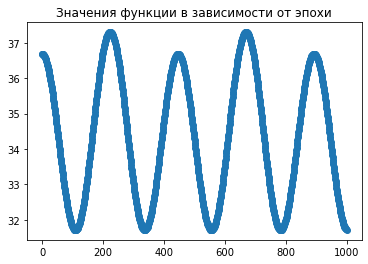

In [4]:
learning_rate = 1e-6
n_epoch = 1000
loss_history, s_history = [], []
loss_min,s_best = None, None
x = torch.from_numpy(sample)
s = torch.tensor([1.], requires_grad= True)

for epoch in range(n_epoch):
    loss = ((x- s * linearSign(x, s)).pow(2)).sum()
    loss.backward()
    s.data -= learning_rate * s.grad.data
    loss_history.append(loss.data)
    s_history.append(s)

    if loss_min == None or loss<loss_min:
        loss_min = loss
        s_best = s

plt.scatter(range(n_epoch),loss_history)
plt.title('Значения функции в зависимости от эпохи')
print('Минимальное значение функции '+str(loss_min.item()))
print('Минимальное значение функции достигается при s='+str(s_best.item()))


## Случай гиперболического тангенса
$$
  \frac{\partial [  sign \left(\frac{x_i} {s} \right)]}{\partial s} = \frac{\partial tanh[\frac{x_i} {s}]}{\partial s} =( 1 - tanh^{2}[\frac{x_i} {s}])* (\frac{-x_i} {s^2}) = \frac{\frac{-x_i} {s^2}}{cosh^2(\frac{x_i} {s})}
$$

In [5]:
class SignTanhFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight):
        ctx.save_for_backward(input, weight)
        output = torch.sign(input/weight)
        return output

    @staticmethod
    def backward(ctx, grad_output):

        input, weight = ctx.saved_tensors
        grad_input = 1./weight
        grad_weight = -input/((weight*torch.cosh(input/weight))**2)

        return  grad_weight  , grad_input

TanhSign = SignTanhFunction.apply


Минимальное значение функции 31.7181887776144
Минимальное значение функции достигается при s=0.7822213768959045


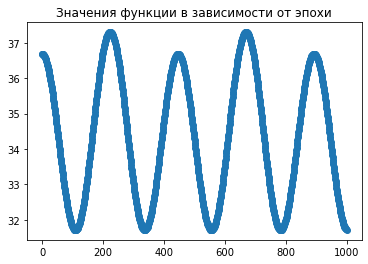

In [6]:
learning_rate = 1e-6
n_epoch = 1000
loss_history, s_history = [], []
loss_min,s_best = None, None
x = torch.from_numpy(sample)
s = torch.tensor([1.], requires_grad= True)

for epoch in range(n_epoch):
    loss = ((x- s * TanhSign(x, s)).pow(2)).sum()
    loss.backward()
    s.data -= learning_rate * s.grad.data
    loss_history.append(loss.data)
    s_history.append(s)

    if loss_min == None or loss<loss_min:
        loss_min = loss
        s_best = s

plt.scatter(range(n_epoch),loss_history)
plt.title('Значения функции в зависимости от эпохи')
print('Минимальное значение функции '+str(loss_min.item()))
print('Минимальное значение функции достигается при s='+str(s_best.item()))

# Ответы для случая градиентного спуска совпадают и достаточно близки по значению к точному аналитическому решению
## Очевидно, что переопределив вычисление производной мы сами сдвинули экстремум, поэтому идеального попадания в аналитическое решение не добиться

In [7]:
torch.cosh(x/s_best).mean()

tensor(2.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)

# величина порядка 2, т.е. вносит изменения на на масштабе 1000 эпох этого почти не заметно

# Так же знак найденного S зависит от начального значения S для случаев градиентного спуска